In [19]:
import torch
from torch.nn.functional import conv2d, softmax
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [20]:
def correlation(image, edge_L, edge_R, isInfrared=False):
    
    img = cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2RGB)
    print("Image shape: H:{}, W:{}, C:{}".format(img.shape[0], img.shape[1], img.shape[2]))
    
    if isInfrared:
        img = img[:,:,1].reshape(img.shape[0], img.shape[1], 1)
        
        print("Infrared process: H:{}, W:{}, C:{}".format(img.shape[0], img.shape[1], img.shape[2]))
        
    cut_out = img[:, edge_L:edge_R, :]
    cut_out_length = edge_R - edge_L
    print("CutOut shape: H:{}, W:{}, C:{}".format(cut_out.shape[0], cut_out.shape[1], cut_out.shape[2]))
    print("Length:{}".format(cut_out_length))
    
    img_Tensor = torch.from_numpy(img.reshape(1,img.shape[2],img.shape[0],img.shape[1]))
    cut_out_Tensor = torch.from_numpy(cut_out.reshape(1,cut_out.shape[2],cut_out.shape[0],cut_out.shape[1]))
    
    match_map = conv2d(img_Tensor, cut_out_Tensor)
    prob = softmax(match_map.view(-1,1).float(), dim = 0)
    prob = prob.numpy()
    
    displacement = np.arange(0, img.shape[1] - cut_out_length+1) - edge_L
    
    abs_error = prob.argmax() - edge_L
    peaks = np.where(prob > prob.max()*0.85)[0] - edge_L
    num_peaks = len(peaks)
    
    plt.figure("output", figsize = (4,8))
    plt.subplot(2,1,1)
    plt.imshow(img)
    plt.subplot(2,1,2)
    plt.imshow(cut_out)
    plt.figure(figsize = (8,4))
    plt.plot(displacement, prob)
    plt.title("Output of correlation")
    plt.xlabel("displacement")
    plt.ylabel("probability")
    plt.show()
    
    return abs_error, num_peaks, match_map, prob, displacement

def log_fusion(prob_ir, prob_rgb, displacement, edge_L):
    fusion_result =  prob_ir * prob_rgb
    print("Shape of ir_result: {}".format(prob_ir.shape))
    print("Shape of rgb_result: {}".format(prob_rgb.shape))
    print("Shape of fusion_result: {}".format(fusion_result.shape))
    
    abs_error = fusion_result.argmax() - edge_L
    peaks = np.where(fusion_result > fusion_result.max()*0.6)[0] - edge_L
    num_peaks = len(peaks)
    
    print("{} peaks, location: {}".format(num_peaks,peaks))
    print("Absolute error: {}".format(abs_error))
    
    plt.figure("fusion_output", figsize = (8,4))
    plt.title("Output of fusion")
    plt.xlabel("displacement")
    plt.ylabel("probability")
    plt.plot(displacement, fusion_result)
    
    return abs_error, peaks, num_peaks

def abs_fusion(cor_value_ir, cor_value_rgb, displacement, edge_L):
    abs_result =  cor_value_rgb * cor_value_ir
#     abs_result_tensor = torch.from_numpy(abs_result)
    
    prob = softmax(abs_result.view(-1,1).float(), dim = 0)
    prob = prob.numpy()
    
    abs_error = prob.argmax() - edge_L
    peaks = np.where(prob > prob.max()*0.6)[0] - edge_L
    num_peaks = len(peaks)
    
    print("{} peaks, location: {}".format(len(peaks),peaks))
    print("Absolute error: {}".format(abs_error))
    
    plt.figure("fusion_output", figsize = (8,4))
    plt.plot(displacement,prob)
    
    return abs_error, peaks, num_peaks

## One cutout in one pair image

Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200


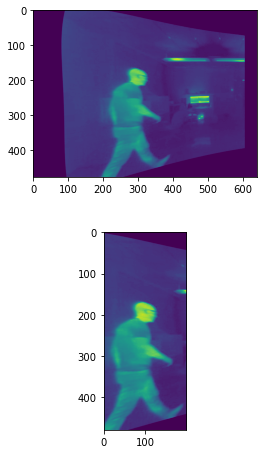

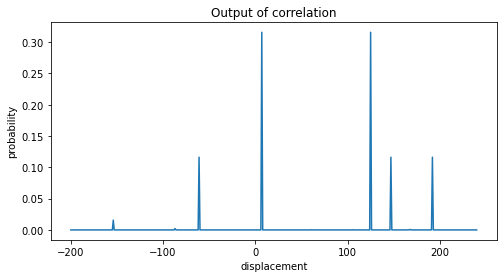

In [10]:
_, _,cor_ir, prob_ir, dis = correlation("video7_ir.png", 200, 400, True)

Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200


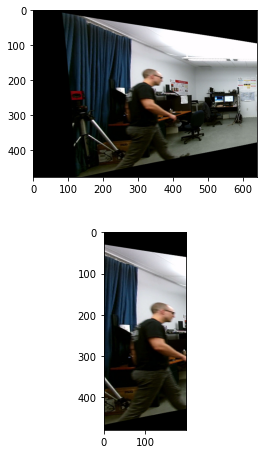

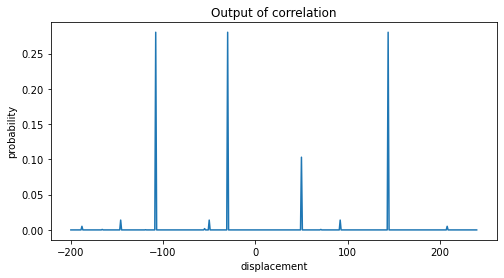

In [11]:
_, _,cor_rgb, prob_rgb, dis = correlation("video7_rgb.png", 200, 400, False)

Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [7]
Absolute error: 7


(7, array([7], dtype=int64), 1)

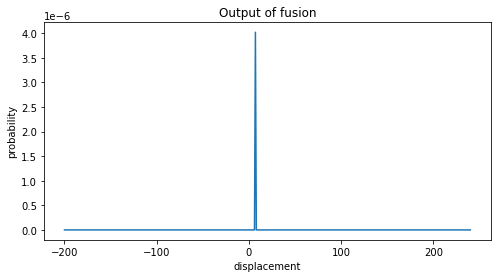

In [12]:
log_fusion(prob_ir, prob_rgb, dis, 200)

1 peaks, location: [99]
Absolute error: 99


(99, array([99], dtype=int64), 1)

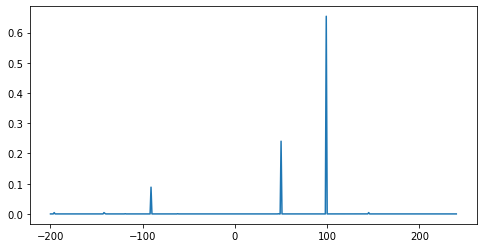

In [13]:
abs_fusion(cor_ir, cor_rgb, dis, 200)

## Multi-cutout in multi-pair images

In [14]:
root = "vid04/"
root_ir = "vid04/lwir/"
root_rgb = "vid04/rgb/"

ir_img_list = os.listdir(root_ir) 
rgb_img_list = os.listdir(root_rgb)

result_fold = [root + "result_ir", root + "result_rgb", root + "result_fusion"]

for folder in result_fold:
    isExist = os.path.exists(folder)
    
    if not isExist:
        os.makedirs(folder)
        print(folder + " is created.")
        
    else:
        print(folder + " is existed.")

vid04/result_ir is existed.
vid04/result_rgb is existed.
vid04/result_fusion is existed.


In [16]:
rgb_img_list = rgb_img_list[:6]
print(rgb_img_list)

ir_img_list = rgb_img_list[:6]
print(ir_img_list)

['00498.png', '00508.png', '00510.png', '00515.png', '00524.png', '00534.png']
['00498.png', '00508.png', '00510.png', '00515.png', '00524.png', '00534.png']


In [21]:
err_fusion_solo = []
err_ir_solo = []
err_rgb_solo = []
num_peaks_solo = []

err_ir_mul = []
err_rgb_mul = []
err_fusion_mul = []

length = 200

for ir_img, rgb_img in zip(ir_img_list, rgb_img_list):
    for i in range(150, 400, 10):
        edge_L = i
        edge_R = i + length
        
        err_ir, num_peaks_ir, match_map_ir, prob_ir, displacement = correlation(root_ir+ir_img, edge_L, edge_R, True)
        err_rgb, num_peaks_rgb, match_map_rgb, prob_rgb, displacement = correlation(root_rgb+rgb_img, edge_L, edge_R, False)

        abs_error, peaks, num_peaks = log_fusion(prob_ir, prob_rgb, displacement, edge_L)
        
        num_peaks_solo.append(num_peaks)
        err_fusion_solo.append(abs_error)
        err_ir_solo.append(err_ir)
        err_rgb_solo.append(err_rgb)
        
    err_ir_mul.append(np.absolute(err_ir_solo).mean())
    err_rgb_mul.append(np.absolute(err_rgb_solo).mean())
    err_fusion_mul.append(np.absolute(err_fusion_solo).mean())
    
    np.save(result_fold[0] + "/" + str(ir_img) + ".npy", np.array(err_ir_solo))
    np.save(result_fold[1] + "/" + str(rgb_img) + ".npy", np.array(err_rgb_solo))
    np.save(result_fold[2] + "/" + str(ir_img) + ".npy", np.array(err_fusion_solo))
    
    err_fusion_solo = []
    err_ir_solo = []
    err_rgb_solo = []
    
err_ir_mul = np.array(err_ir_mul).reshape(-1,1)
err_rgb_mul = np.array(err_rgb_mul).reshape(-1,1)
err_fusion_mul = np.array(err_fusion_mul).reshape(-1,1)

np.save(result_fold[0] + "/" + "ir_all_imgs.npy", np.array(err_ir_mul))
np.save(result_fold[1] + "/" + "rgb_all_imgs.npy", np.array(err_rgb_mul))
np.save(result_fold[2] + "/" + "fusion_all_imgs.npy", np.array(err_fusion_mul))

Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [16]
Absolute error: 16
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [130]
Absolute error: 130
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [-80]
Absolute error: -80
Image shape: H:480, W:640, C:3
Infrared

Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
2 peaks, location: [-147   13]
Absolute error: -147
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [75]
Absolute error: 75
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [75]
Absolute error: 75
Image shape: H:480, W:640, C:3
Inf

Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [202]
Absolute error: 202
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [58]
Absolute error: 58
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [143]
Absolute error: 143
Image shape: H:480, W:640, C:3
Infrared

Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [4]
Absolute error: 4
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [160]
Absolute error: 160
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [-9]
Absolute error: -9
Image shape: H:480, W:640, C:3
Infrared pro

Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [-57]
Absolute error: -57
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [25]
Absolute error: 25
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [-212]
Absolute error: -212
Image shape: H:480, W:640, C:3
Infrar

1 peaks, location: [36]
Absolute error: 36
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [-229]
Absolute error: -229
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [-188]
Absolute error: -188
Image shape: H:480, W:640, C:3
Infrared process: H:480, W:640, C:1
CutOut shape: H:480, W:200, C:1
Length:200
Image shape: H:480, W:640, C:3
CutOut shape: H:480, W:200, C:3
Length:200
Shape of ir_result: (441, 1)
Shape of rgb_result: (441, 1)
Shape of fusion_result: (441, 1)
1 peaks, location: [10]
Absolute er

Mean MAE of ir-img: 152.26666666666668
Mean MAE of rgb-img: 147.8
Mean MAE of fusion: 126.73333333333333


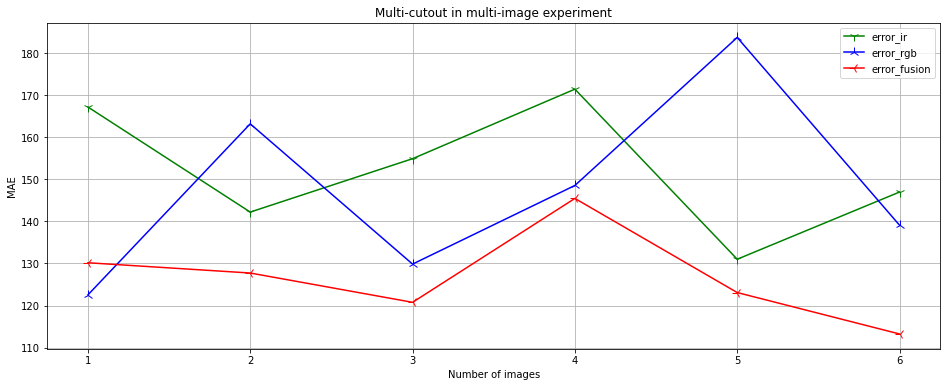

In [18]:
x_axis = np.arange(1, len(ir_img_list)+1)
print("Mean MAE of ir-img: {}".format(err_ir_mul.mean()))
print("Mean MAE of rgb-img: {}".format(err_rgb_mul.mean()))
print("Mean MAE of fusion: {}".format(err_fusion_mul.mean()))

plt.figure(figsize = (16,6))

plt.plot(x_axis,err_ir_mul, '-g', marker = "1", markersize = 10, label = "error_ir")
plt.plot(x_axis,err_rgb_mul, '-b',marker = "2", markersize = 10, label = "error_rgb")
plt.plot(x_axis,err_fusion_mul, '-r', marker = "3", markersize = 10, label = "error_fusion")

plt.title("Multi-cutout in multi-image experiment")
plt.xlabel("Number of images")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.xticks(x_axis)
plt.show()